Training with RMSProp (learning rate=0.0001, rho=0.9)...
Training with RMSProp (learning rate=0.0001, rho=0.95)...
Training with RMSProp (learning rate=0.0001, rho=0.99)...
Training with RMSProp (learning rate=0.001, rho=0.9)...
Training with RMSProp (learning rate=0.001, rho=0.95)...
Training with RMSProp (learning rate=0.001, rho=0.99)...
Training with RMSProp (learning rate=0.01, rho=0.9)...
Training with RMSProp (learning rate=0.01, rho=0.95)...
Training with RMSProp (learning rate=0.01, rho=0.99)...
Miglior learning rate: 0.001, Miglior rho: 0.99
Final Train Loss: 0.3451, Final Val Loss: 0.3487
Final Train Accuracy: 0.8468, Final Val Accuracy: 0.8380
Test Loss: 0.3947, Test Accuracy: 0.8097


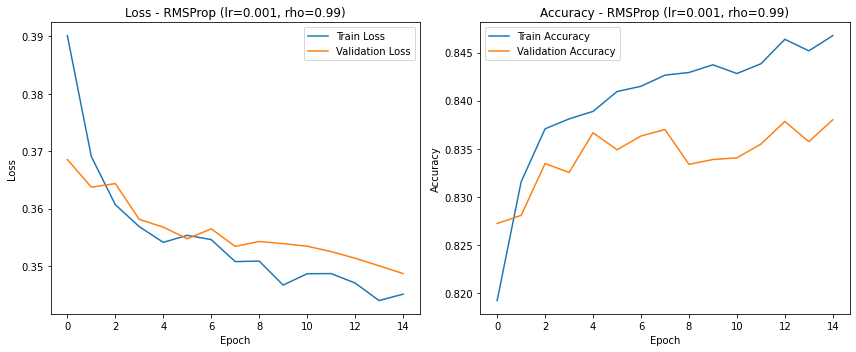

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Caricamento dei dati
train_df = pd.read_csv('dataset/train_data.csv')
test_df = pd.read_csv('dataset/test_data.csv')

# Preprocessing
X_train = train_df.drop(columns=['income']).values
y_train = train_df['income'].values
X_test = test_df.drop(columns=['income']).values
y_test = test_df['income'].values

# Standardizzazione delle feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applicazione di SMOTE per bilanciare il dataset di addestramento
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Convertiamo le feature e le target in tensori
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Creiamo il dataset e dividiamolo in training e validation
full_train_dataset = CustomDataset(X_train, y_train)
train_size = int(0.8 * len(full_train_dataset))  # 80% per il training
val_size = len(full_train_dataset) - train_size  # 20% per la validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(CustomDataset(X_test, y_test), batch_size=32, shuffle=False)

# Definizione della rete MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Funzione di training
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    corrects = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (outputs >= 0.5).float()
        corrects += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = corrects / total
    return epoch_loss, epoch_accuracy

# Funzione di valutazione
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs >= 0.5).float()
            corrects += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = corrects / total
    return epoch_loss, epoch_accuracy

# Funzione per eseguire la ricerca con RMSProp
def line_search_rmsprop(learning_rates, rhos, num_epochs, model, criterion, train_loader, val_loader, device):
    best_lr = None
    best_rho = None
    best_val_accuracy = 0
    best_result = None

    for lr in learning_rates:
        for rho in rhos:
            print(f"Training with RMSProp (learning rate={lr}, rho={rho})...")
            model = MLP(input_size=X_train.shape[1]).to(device)
            optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=rho)

            train_losses, train_accuracies = [], []
            val_losses, val_accuracies = [], []

            for epoch in range(num_epochs):
                train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
                val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

                train_losses.append(train_loss)
                train_accuracies.append(train_accuracy)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

            # Se la validazione accuracy è la migliore, aggiorna il miglior learning rate e rho
            if val_accuracies[-1] > best_val_accuracy:
                best_val_accuracy = val_accuracies[-1]
                best_lr = lr
                best_rho = rho
                best_result = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                }

    return best_lr, best_rho, best_result

# Parametri per la ricerca
learning_rates = [0.0001, 0.001, 0.01]  # 3 valori di learning rate
rhos = [0.9, 0.95, 0.99]  # 3 valori di rho
num_epochs = 15

# Criterio di perdita
criterion = nn.BCELoss()

# Esegui la line search
best_lr, best_rho, best_result = line_search_rmsprop(learning_rates, rhos, num_epochs, MLP(input_size=X_train.shape[1]), criterion, train_loader, val_loader, device)

# Stampa del miglior learning rate e rho
print(f"Miglior learning rate: {best_lr}, Miglior rho: {best_rho}")
print(f"Final Train Loss: {best_result['train_losses'][-1]:.4f}, Final Val Loss: {best_result['val_losses'][-1]:.4f}")
print(f"Final Train Accuracy: {best_result['train_accuracies'][-1]:.4f}, Final Val Accuracy: {best_result['val_accuracies'][-1]:.4f}")

# Valutazione finale sul test set con i migliori iperparametri
final_model = MLP(input_size=X_train.shape[1]).to(device)
final_optimizer = optim.RMSprop(final_model.parameters(), lr=best_lr, alpha=best_rho)  # Usa RMSProp
final_model.train()

# Allenamento finale con tutto il training set
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(final_model, train_loader, criterion, final_optimizer, device)

# Valutazione finale sul test set
test_loss, test_accuracy = evaluate(final_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Grafico dell'andamento della Loss e Accuracy per i migliori iperparametri
plt.figure(figsize=(12, 5))

# Grafico della Loss
plt.subplot(1, 2, 1)
plt.plot(best_result['train_losses'], label='Train Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title(f'Loss - RMSProp (lr={best_lr}, rho={best_rho})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafico dell'Accuracy
plt.subplot(1, 2, 2)
plt.plot(best_result['train_accuracies'], label='Train Accuracy')
plt.plot(best_result['val_accuracies'], label='Validation Accuracy')
plt.title(f'Accuracy - RMSProp (lr={best_lr}, rho={best_rho})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"rmsprop_lr_{best_lr}_rho_{best_rho}_loss_accuracy.png")  # Salva il grafico come PNG
plt.show()
